In [14]:
import os

# Set the correct Java path for PySpark
os.environ["JAVA_HOME"] = "/storage/icds/RISE/sw8/jdk-20.0.1"
os.environ["PATH"] = os.path.join(os.environ["JAVA_HOME"], "bin") + ":" + os.environ["PATH"]


import pandas as pd 
import numpy as np 
import math 
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader 
from torchvision import datasets 
from torchvision.transforms import ToTensor 
import matplotlib.pyplot as plt  
import sklearn as sk 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import pyspark 
from pyspark import SparkContext 
from pyspark.sql import SparkSession 
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType 
from pyspark.sql.functions import col, column 
from pyspark.sql.functions import expr 
from pyspark.sql.functions import split 
from pyspark.sql import Row
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

ss=SparkSession.builder.master("local").appName("DS340 Project").getOrCreate()
ss.sparkContext.setCheckpointDir("~/scratch")

staffing_schema = StructType([
    StructField("year", IntegerType(), True),
    StructField("oshpd_id", IntegerType(), True),
    StructField("county_Name", IntegerType(), False),
    StructField("er_service_level_desc", IntegerType(), False),
    StructField("type", IntegerType(), False),
    StructField("count", IntegerType(), True)
])

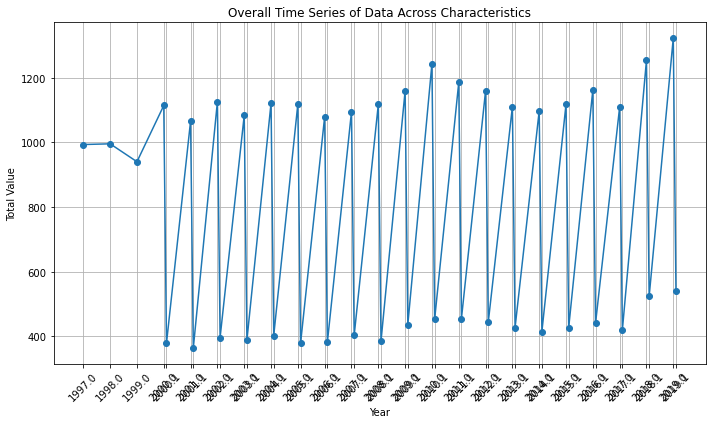

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Your data cleaning steps (same as before) ---
df = pd.read_excel("edad.xlsx", skiprows=4)
df.columns = df.columns.map(str)
df = df.rename(columns={df.columns[0]: "Characteristic"})
df = df.loc[:, ~df.columns.str.contains("SE", case=False, na=False)]
df = df.loc[:, ~df.columns.duplicated(keep="first")]
df = df.dropna(how="all")
df = df[df["Characteristic"].notna()]
df["Characteristic"] = df["Characteristic"].astype(str).str.strip()

numeric_cols = df.columns.drop("Characteristic")
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=numeric_cols, how="all")

# --- Time Series Plot ---

# Sum across all characteristics for each column
time_series = df[numeric_cols].sum()

# Clean column names: remove any non-numeric characters like .1, .2
clean_cols = []
for col in numeric_cols:
    # Extract the numeric part
    match = re.search(r"\d+\.?\d*", col)
    if match:
        clean_cols.append(float(match.group()))
    else:
        clean_cols.append(col)  # fallback, shouldn't happen

time_series.index = clean_cols

# Sort by year
time_series = time_series.sort_index()

# Convert to numpy arrays
x = np.array(time_series.index)
y = np.array(time_series.values)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.title("Overall Time Series of Data Across Characteristics")
plt.xlabel("Year")
plt.ylabel("Total Value")
plt.grid(True)
plt.xticks(x, rotation=45)
plt.tight_layout()
plt.show()

In [11]:
ss.stop()